# Hands-on: Training the AIFS-ENS with Anemoi

In this tutorial we will learn how to train the AIFS-ENS (ensemble) model using the anemoi packages. We'll focus on the CRPS (Continuous Ranked Probability Score) based training approach, which is specifically designed for ensemble weather forecasting.

**Learning Objectives**

By the end of this tutorial, you will:
- Understand the key differences between deterministic and ensemble CRPS training
- Learn how to configure the anemoi training pipeline for ensemble models
- Build a minimal training configuration step-by-step
- Execute a short training run to verify everything works


**Resources**

- [Anemoi docu: CRPS-based training](https://anemoi.readthedocs.io/projects/training/en/latest/user-guide/kcrps-set-up.html)
- [Anemoi Documentation](https://anemoi.readthedocs.io/projects/training/en/latest/)
- [Lang et al. 2024](http://arxiv.org/abs/2412.15832)

## Background: What is CRPS Training?

The **Continuous Ranked Probability Score (CRPS)** is a proper scoring rule for evaluating probabilistic forecasts. In the context of ensemble weather forecasting, CRPS training allows us to train models that produce multiple ensemble members, each representing a different possible future state of the atmosphere.

<img src="_resources/aifs-crps_sketch.png" alt="CRPS Sketch" width="900">

### Why Ensemble Training?

- **Uncertainty Quantification**: Each ensemble member represents a different possible future
- **Probabilistic Forecasting**: Provides uncertainty estimates alongside predictions
- **Better Skill Scores**: Often outperforms deterministic models in terms of skill metrics
- **Operational Use**: Essential for weather services that need to communicate forecast uncertainty




## CRPS Training in Anemoi

### Key Differences: Deterministic vs CRPS Training

The main components of the training pipeline need to be modified when switching from deterministic to ensemble CRPS training:

| Component | Deterministic | CRPS |
|-----------|---------------|------|
| **Forecaster** | `GraphForecaster` | `GraphEnsForecaster` |
| **Strategy** | `DDPGroupStrategy` | `DDPEnsGroupStrategy` |
| **Training Loss** | `WeightedMSELoss` | `AlmostFairKernelCRPS` |
| **Model** | `AnemoiModelEncProcDec` | `AnemoiEnsModelEncProcDec` |
| **Datamodule** | `AnemoiDatasetsDataModule` | `AnemoiEnsDatasetsDataModule` |


#### The AlmostFairKernelCRPS Loss

The training uses the AlmostFairKernelCRPS loss function, which combines the traditional CRPS with a "fair" version:

$$\text{afCRPS}_\alpha := \alpha\text{fCRPS} + (1-\alpha)\text{CRPS}$$

Where $\alpha$ is a trade-off parameter between the CRPS and the fair CRPS.


## Building Our Training Config

Now we'll examine our training configuration step-by-step, highlighting the key differences from deterministic training. We have a minimal configuration file ready that we'll load and examine section by section.

In [1]:
# Let's start by importing the necessary modules
import yaml
from omegaconf import OmegaConf
from pathlib import Path

# Load our minimal configuration file
config_path = Path("configs/aifs_ens_minimal.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


### Step 1: Hardware Configuration

The hardware configuration needs to specify the number of GPUs per ensemble, which is crucial for the ensemble training strategy.

**Key Points:**
- `num_gpus_per_ensemble`: Number of GPUs to use per ensemble (typically 1 for small setups)
- `num_gpus_per_model`: Number of GPUs per model instance
- Total ensemble members = `ensemble_size_per_device` × `num_gpus_per_ensemble` (we'll set this later)


In [2]:
# Display the hardware configuration section
print("Hardware Configuration:")
print("=" * 50)
print(yaml.dump(config['hardware'], default_flow_style=False))


Hardware Configuration:
accelerator: auto
files:
  dataset: aifs-ea-an-oper-0001-mars-o48-2010-2022-6h-v1-toy.zarr
num_gpus_per_ensemble: 1
num_gpus_per_model: 1
paths:
  data: /datasets/
  output: /home/${oc.env:USER}/anemoi-output/



### Step 2: Datamodule Configuration

For ensemble training, we need to use the `AnemoiEnsDatasetsDataModule` instead of the regular datamodule. This handles ensemble data loading and can work with either:
- Single initial conditions for all ensemble members
- Perturbed initial conditions (if available in your dataset)


In [3]:
print("Datamodule configuration:")
print("=" * 50)
print(yaml.dump(config['datamodule'], default_flow_style=False))


Datamodule configuration:
_target_: anemoi.training.data.datamodule.AnemoiEnsDatasetsDataModule



### Step 3: Model Configuration

Key model changes for CRPS-based training are:

1. **Ensemble Model Class**: Uses `AnemoiEnsModelEncProcDec` instead of `AnemoiModelEncProcDec`

2. **Noise Injector**: Each ensemble member samples random noise at every time step:
   ```yaml
   noise_injector:
     _target_: anemoi.models.layers.ensemble.NoiseConditioning
     noise_std: 1
     noise_channels_dim: 4
     noise_mlp_hidden_dim: 32
     inject_noise: True
   ```

3. **Conditional Layer Normalization**: The processor uses `ConditionalLayerNorm` instead of regular `LayerNorm` to condition the latent space on the noise:
   ```yaml
   processor:
     layer_kernels:
       LayerNorm:
         _target_: anemoi.models.layers.normalization.ConditionalLayerNorm
         normalized_shape: ${model.num_channels}
         condition_shape: ${model.noise_injector.noise_channels_dim}
   ```

   Unlike standard layer normalization that normalizes features independently, conditional layer normalization allows the normalization to be conditioned on additional information (in this case, noise vectors).
    - Each ensemble member gets a unique noise vector at every time step
    - This noise is embedded and used to condition the layer normalization in the processor
    - The conditioning allows the same model weights to produce different outputs for different ensemble members
    - This creates diversity in the ensemble predictions while sharing computational resources


This noise injection and conditioning is what allows each ensemble member to produce different predictions while sharing the same model weights.

In [4]:
# Display the model configuration section
print("Model Configuration:")
print("=" * 30)
print(yaml.dump(config['model'], default_flow_style=False))


Model Configuration:
model:
  _target_: anemoi.models.models.AnemoiEnsModelEncProcDec
noise_injector:
  _target_: anemoi.models.layers.ensemble.NoiseConditioning
  inject_noise: true
  layer_kernels:
    Activation:
      _target_: torch.nn.GELU
  noise_channels_dim: 4
  noise_mlp_hidden_dim: 32
  noise_std: 1
num_channels: 128
processor:
  layer_kernels:
    LayerNorm:
      _target_: anemoi.models.layers.normalization.ConditionalLayerNorm
      autocast: false
      condition_shape: ${model.noise_injector.noise_channels_dim}
      normalized_shape: ${model.num_channels}
      w_one_bias_zero_init: true
  num_layers: 8



### Step 4: Training Configuration

Now we configure the training parameters, strategy, and loss function for ensemble training.

**Key Training Parameters:**

1. **Model Task**: Set to `GraphEnsForecaster` (handled by the `ensemble` training default)
2. **Ensemble Size**: `ensemble_size_per_device: 2` means 2 ensemble members per device. Thus, the **Total Ensemble Members** is:
    ```
   ensemble_size_per_device × num_nodes x num_gpus_per_node / ( num_gpus_per_member x num_gpus_per_mod) = 2 × 1 x 1 / (1 x 1) = 2 members
   ```
   
3. **Strategy**: Uses `DDPEnsGroupStrategy` (handled by the `ensemble` training default)
4. **Loss Function**: `AlmostFairKernelCRPS` with `alpha=1.0` (pure fair CRPS)


In [5]:
# Display the training configuration section
print("Training Configuration:")
print("=" * 30)
print(yaml.dump(config['training'], default_flow_style=False))


Training Configuration:
ensemble_size_per_device: 2
lr:
  iterations: ${training.max_steps}
  min: 3e-7
  rate: 1e-3
  warmup: 1000
max_epochs: null
max_steps: 16
model_task: anemoi.training.train.tasks.GraphEnsForecaster
strategy:
  _target_: anemoi.training.distributed.strategy.DDPEnsGroupStrategy
  num_gpus_per_ensemble: ${hardware.num_gpus_per_ensemble}
  num_gpus_per_model: ${hardware.num_gpus_per_model}
  read_group_size: ${dataloader.read_group_size}
training_loss:
  _target_: anemoi.training.losses.kcrps.AlmostFairKernelCRPS
  alpha: 1.0
  ignore_nans: false
  scalers:
  - pressure_level
  - general_variable
  - nan_mask_weights
  - node_weights
validation_metrics:
  fkcrps:
    _target_: anemoi.training.losses.kcrps.AlmostFairKernelCRPS
    alpha: 1.0
    ignore_nans: false
    scalers:
    - node_weights



## Training Execution

Now that we have our configuration ready, let's execute the training. We'll run a short training session to verify everything works correctly by running,

```bash
export ANEMOI_BASE_SEED=42
anemoi-training train --config-path ./config --config-name aifs_ens_minimal
```

In [ ]:
import subprocess
import sys, os 

# Set environment variables
os.environ['ANEMOI_BASE_SEED'] = '42'
os.environ['POSSIBLE_USER_WARNINGS'] = 'off'
os.environ['TORCH_LOGS'] = "-dynamo,-inductor"

# Execute the training using subprocess
print("Starting AIFS-ENS training...")
print("=" * 50)

process = subprocess.Popen(
    [
        "anemoi-training", "train", 
        "--config-path", "PATH-TO-CONFIGS", 
        "--config-name", "aifs_ens_minimal.yaml"
    ], 
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,  # Merge stderr into stdout
    text=True,
    bufsize=1,  # Line buffered
    universal_newlines=True
)

# Stream output
for line in iter(process.stdout.readline, ''):
    if line:
        print(line.rstrip())  # Print immediately to Jupyter cell

# Wait for completion
return_code = process.wait()

print("=" * 50)
if return_code == 0:
    print("✓ Training completed successfully!")
else:
    print(f"❌ Training failed with return code {return_code}")

## Monitoring and Results

### MLflow logging

Several metrics and parameters are logged during training. Here, we use MLflow to log results offline. 

In the following we use the MLflow API to plot some key metrics during training, such as:

- **Training Loss**: The AlmostFairKernelCRPS loss should decrease over time
- **Validation Metrics**: Similar to training loss, calculated on validation data

*Note:* Typically the logging is done to a server and can be used interactively on a website.


In [7]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

run_id="e14f2a7cf8a34b40a2df27b254f021fe"

# Start mlflow client and load run
client = mlflow.tracking.MlflowClient(tracking_uri=f"file:///home/{os.getenv("USER")}/anemoi-output/logs/mlflow")
run = client.get_run(run_id)

print(f"Run name: {run.info.run_name}")
print("Logged metrics:")
print("=" * 50)
for k in run.data.metrics.keys():
    print(k)


Run name: f6f383de-e4fa-4585-902c-4781e42d30c7
Logged metrics:
train_afkcrps1.00_epoch
val_afkcrps1.00_epoch
val_afkcrps1.00_step
epoch
val_fkcrps_metric/sfc_tp/1
val_fkcrps_metric/sfc_tcw/1
val_fkcrps_metric/pl_t/1
val_fkcrps_metric/all/1
val_fkcrps_metric/pl_z/1
val_fkcrps_metric/t_850/1
val_fkcrps_metric/sfc_2t/1
val_fkcrps_metric/z_500/1
val_fkcrps_metric/sfc_cp/1


Text(0, 0.5, 'loss')

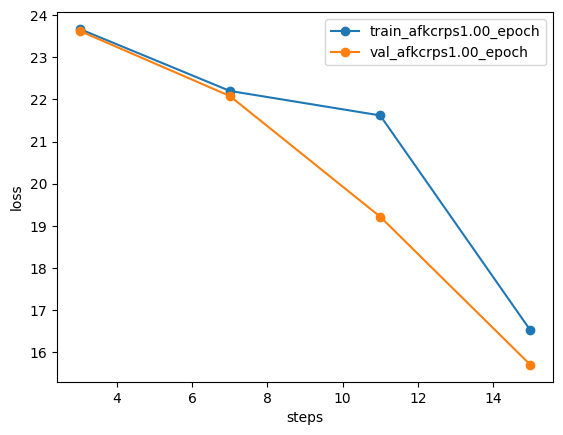

In [8]:
# Plotting 
metric_names = ['train_afkcrps1.00_epoch', 'val_afkcrps1.00_epoch']

# Load data into DataFrame
data = []
for metric in metric_names:
    for entry in client.get_metric_history(run_id, metric):
        data.append({'metric': metric, 'step': entry.step, 'value': entry.value, 'time': entry.timestamp})
df = pd.DataFrame(data)

# Plot all metrics
fig, ax = plt.subplots()
for metric in df['metric'].unique():
    metric_data = df[df['metric'] == metric].sort_values('step')
    ax.plot(metric_data['step'], metric_data['value'], '-o', label=metric)
ax.legend()
ax.set_xlabel('steps')
ax.set_ylabel('loss')


### Task 1: Change the number of ensemble members

Adapt the training config and retrain the model with:
   - a larger number of ensemble members, e.g. `ensemble_size_per_device=4`
   - train the model for longer by increasing the number of iterations (`max_steps`)

**Questions**
- How does your loss change with the same number of steps? 
- How much longer does the training take per iteration?
- What happens if you choose a large number of ensemble members?

***Note***:

You do not need to do the training in the notebook. You can run on the console with: 
```
anemoi-training train --config-path PATH-TO-YOUR-CONFIG-FOLDER --config-name aifs_ens_minimal_config
```

### (Optional) Task 2: Inference of your model

Run inference on the model you have trained. For that, go back to the Jupyter notebook `../4-run-AIFS/inference_aifs-ens.ipynb` and import your used checkpoint. 

***Note:***

You need to adapt, 
1. The resolution of the data for your input fields to O48

```
GRID_RESOLUTION = "O48"
PARAM_SFC = ["2t", 'z', 'lsm', "tcw", "sdor", "slor"]
PARAM_PL = ["gh", "t"]
LEVELS = [1000, 850, 700, 500, 300, 250]
```

2. Select only the input fields you need, i.e. ['z_1000', 'z_500', 'z_700', 'z_300', '2t', 't_850', 'tcw', 'z_250', 'lsm', 'z', 'sdor', 'slor'] 


In case you were not able to train the checkpoint. You can download a checkpoint from here:
[https://object-store.os-api.cci1.ecmwf.int/ml-tests/test-data/samples/training-course/inference-aifs-ens-o48.ckpt](https://object-store.os-api.cci1.ecmwf.int/ml-tests/test-data/samples/training-course/inference-aifs-ens-o48.ckpt)
